# Anchor-Probe Hidden Distance
**Goal**: Analyze the distance between the hidden representation of each set of anchors and their probes

In [1]:
from tqdm import tqdm
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.metrics.pairwise import cosine_distances, manhattan_distances
sns.set_style('darkgrid')

# Load Data

In [2]:
LAYER = 'hidden'

In [3]:
# Load anchor-probes mapping
anchor_probe_mapping = pd.read_pickle(f'../../dataset/anchor_probe_mapping_dilution_3.pkl')
anchor_probe_mapping = anchor_probe_mapping.rename(columns={'probes': 'probe'})
anchor_probe_mapping.head()

,anchor,probe,type
0,"[slit, dit, yit]","[vlit, plit, trit, drit]",REG
1,"[thax, chax, brax]","[frax, drax, prax, shrax]",REG
2,"[kleef, pleef, smeef]","[bleef, gleef, creef, preef]",REG
3,"[krim, plim, drim]","[blim, clim, shrim, frim]",REG
4,"[nisp, fisp, chisp]","[bisp, kisp, risp, tisp]",REG


In [4]:
all_anchors_data = []
all_probes_data = []


for dilution in tqdm(range(1, 4)):
    # ANCHORS
    anchor_list = sum(anchor_probe_mapping['anchor'].apply(lambda x: x[:dilution]).tolist(), [])
    anchor_types = [f"ANC_{i}" for i in ['REG', 'EXC', 'AMB']]
    
    anchor_data = pd.concat([pd.read_pickle(f'pmsp-recurrent-dt-100-seed-1/activations-anchors-{LAYER}.pkl'),
                             pd.read_pickle(f'pmsp-recurrent-dt-100-dilution-{dilution}-seed-1/activations-anchors-{LAYER}.pkl')])
    
    anchor_data = anchor_data[anchor_data['word_type'].isin(anchor_types)]
    anchor_data = anchor_data[anchor_data['orth'].isin(anchor_list)]
    anchor_data = anchor_data.drop_duplicates(subset=['epoch', 'orth'])
    anchor_data['dilution'] = dilution
    all_anchors_data.append(anchor_data)
    
    # PROBES
    probe_types = [f"PRO_{i}" for i in ['REG', 'EXC', 'AMB']]
    
    probe_data = pd.concat([pd.read_pickle(f'pmsp-recurrent-dt-100-seed-1/activations-probes-{LAYER}.pkl'),
                            pd.read_pickle(f'pmsp-recurrent-dt-100-dilution-{dilution}-seed-1/activations-probes-{LAYER}.pkl')])
    
    probe_data = probe_data[probe_data['word_type'].isin(probe_types)]
    probe_data = probe_data.drop_duplicates(subset=['epoch', 'orth'])
    probe_data['dilution'] = dilution
    all_probes_data.append(probe_data)

all_anchors_data = pd.concat(all_anchors_data).reset_index(drop=True)
all_probes_data = pd.concat(all_probes_data).reset_index(drop=True)

100%|██████████| 3/3 [00:12<00:00,  4.19s/it]


In [5]:
all_anchors_data.head()

,epoch,hidden,word_id,orth,phon,word_type,dilution
0,0,"[0.5810385, 0.03448805, 0.7988132, 0.9942407, ...",0,slit,slit,ANC_REG,1
1,0,"[0.5104707, 0.2259514, 0.4384914, 0.9883878, 0...",34,drace,dro,ANC_EXC,1
2,0,"[0.7540455, 0.4483854, 0.2318757, 0.99431, 0.4...",8,shing,SiN,ANC_REG,1
3,0,"[0.4388078, 0.1719238, 0.6234508, 0.9161762, 0...",39,suff,sUf,ANC_EXC,1
4,0,"[0.2659034, 0.02671888, 0.1501291, 0.9853213, ...",36,geam,jem,ANC_EXC,1


In [6]:
all_probes_data.head()

,epoch,hidden,word_id,orth,phon,word_type,dilution
0,0,"[0.373897, 0.03446266, 0.2112158, 0.9945962, 0...",19,tisp,tisp,PRO_REG,1
1,0,"[0.3733159, 0.2963167, 0.3179447, 0.992294, 0....",100,blone,blan,PRO_AMB,1
2,0,"[0.3826611, 0.1655288, 0.3533417, 0.9962382, 0...",23,smig,smig,PRO_REG,1
3,0,"[0.6348886, 0.3160738, 0.3828613, 0.9680415, 0...",43,prot,prOt,PRO_EXC,1
4,0,"[0.623893, 0.1842021, 0.1536709, 0.9782502, 0....",5,drax,drks,PRO_REG,1


## Calculation of Distance

We use two distance metrics - cosine distance, and L1 distance. The documentation for these two distance metrics are available here:
* [Cosine Distance](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.cosine_distances.html#sklearn.metrics.pairwise.cosine_distances)
* [Manhattan Distance](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.manhattan_distances.html#sklearn.metrics.pairwise.manhattan_distances)

In [7]:
results = []
for dilution in [1, 2, 3]:
    dilution_anchors_data = all_anchors_data[all_anchors_data['dilution'] == dilution]
    dilution_probes_data = all_probes_data[all_probes_data['dilution'] == dilution]

    for i, row in tqdm(anchor_probe_mapping.iterrows(), total=len(anchor_probe_mapping), desc=f"Dilution {dilution}"):
        anchor_data = dilution_anchors_data[dilution_anchors_data['orth'].isin(row['anchor'])]
        probe_data = dilution_probes_data[dilution_probes_data['orth'].isin(row['probe'])]
        for epoch in anchor_data['epoch'].unique():
            epoch_anchor_data = np.array(anchor_data[anchor_data['epoch'] == epoch][LAYER].tolist())
            epoch_probe_data = np.array(probe_data[probe_data['epoch'] == epoch][LAYER].tolist())

            results.append({
                'dilution': dilution,
                'epoch': epoch,
                f'anchors': row['anchor'],
                'type': row['type'],
                'cosine_distances': cosine_distances(epoch_anchor_data, epoch_probe_data),
                'l1_distances': manhattan_distances(epoch_anchor_data, epoch_probe_data)
            })

Dilution 3: 100%|██████████| 27/27 [00:05<00:00,  4.95it/s]


In [8]:
results_df = pd.DataFrame(results)
results_df['mean_cosine_distance'] = results_df['cosine_distances'].apply(lambda x: x.mean())
results_df['mean_l1_distance'] = results_df['l1_distances'].apply(lambda x: x.mean())
results_df[f'first_anchor'] = results_df[f'anchors'].apply(lambda x: x[0])
results_df = results_df.sort_values(by=['epoch', 'type', f'first_anchor']).reset_index(drop=True)

In [9]:
results_df.head()

,dilution,epoch,anchors,type,cosine_distances,l1_distances,mean_cosine_distance,mean_l1_distance,first_anchor
0,1,0,"[blome, clome, flome]",AMB,"[[0.03469409475429086, 0.039871777802815145, 0...","[[11.139752916800004, 11.832409558300006, 10.5...",0.035289,11.017450,blome
1,2,0,"[blome, clome, flome]",AMB,"[[0.03422744385057386, 0.03220059209060122, 0....","[[11.059413526300002, 10.4731802268, 10.866502...",0.034397,10.877085,blome
2,3,0,"[blome, clome, flome]",AMB,"[[0.03422744385057397, 0.03220059209060122, 0....","[[11.059413526300002, 10.4731802268, 10.866502...",0.034633,10.949282,blome
3,1,0,"[clead, smead, pread]",AMB,"[[0.04173656699174477, 0.013971574338871084, 0...","[[11.707970676000004, 7.240453827999999, 7.699...",0.023607,8.677430,clead
4,2,0,"[clead, smead, pread]",AMB,"[[0.032859572697349404, 0.025801139393254457, ...","[[10.269104875000004, 9.051903832999999, 7.962...",0.023523,8.685253,clead


In [10]:
results_df = results_df[results_df['epoch'] >= 100]

## Mean Cosine and L1 Distance by Type

In [11]:
TYPE = 'Anchor/Probe'

This first pair of graphs aggregate dilution 2 and 3 together.

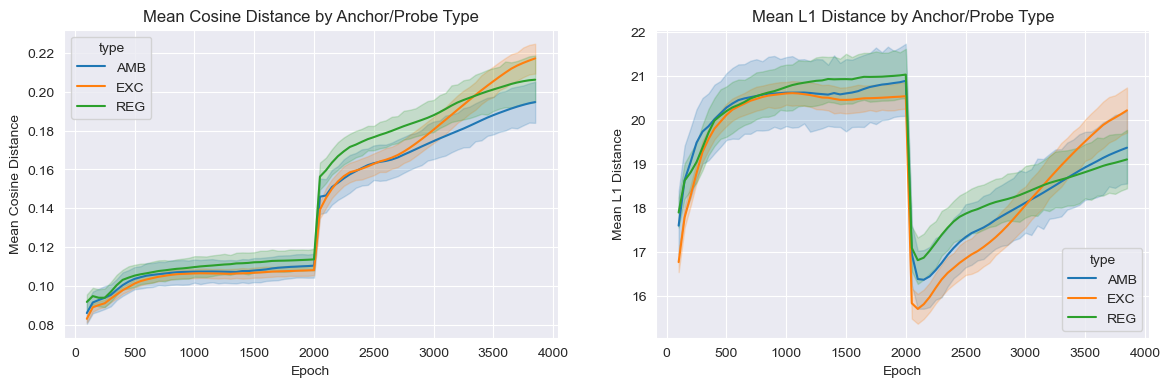

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))

sns.lineplot(data=results_df, x='epoch', y='mean_cosine_distance', hue='type', ax=ax1, ci=68)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Mean Cosine Distance')
ax1.set_title(f'Mean Cosine Distance by {TYPE.title()} Type')

sns.lineplot(data=results_df, x='epoch', y='mean_l1_distance', hue='type', ax=ax2, ci=68)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Mean L1 Distance')
ax2.set_title(f'Mean L1 Distance by {TYPE.title()} Type')

plt.show()

In the next 3 sets of graphs, we look at each regularity type individually, but combine all three dilution levels in the same plot.

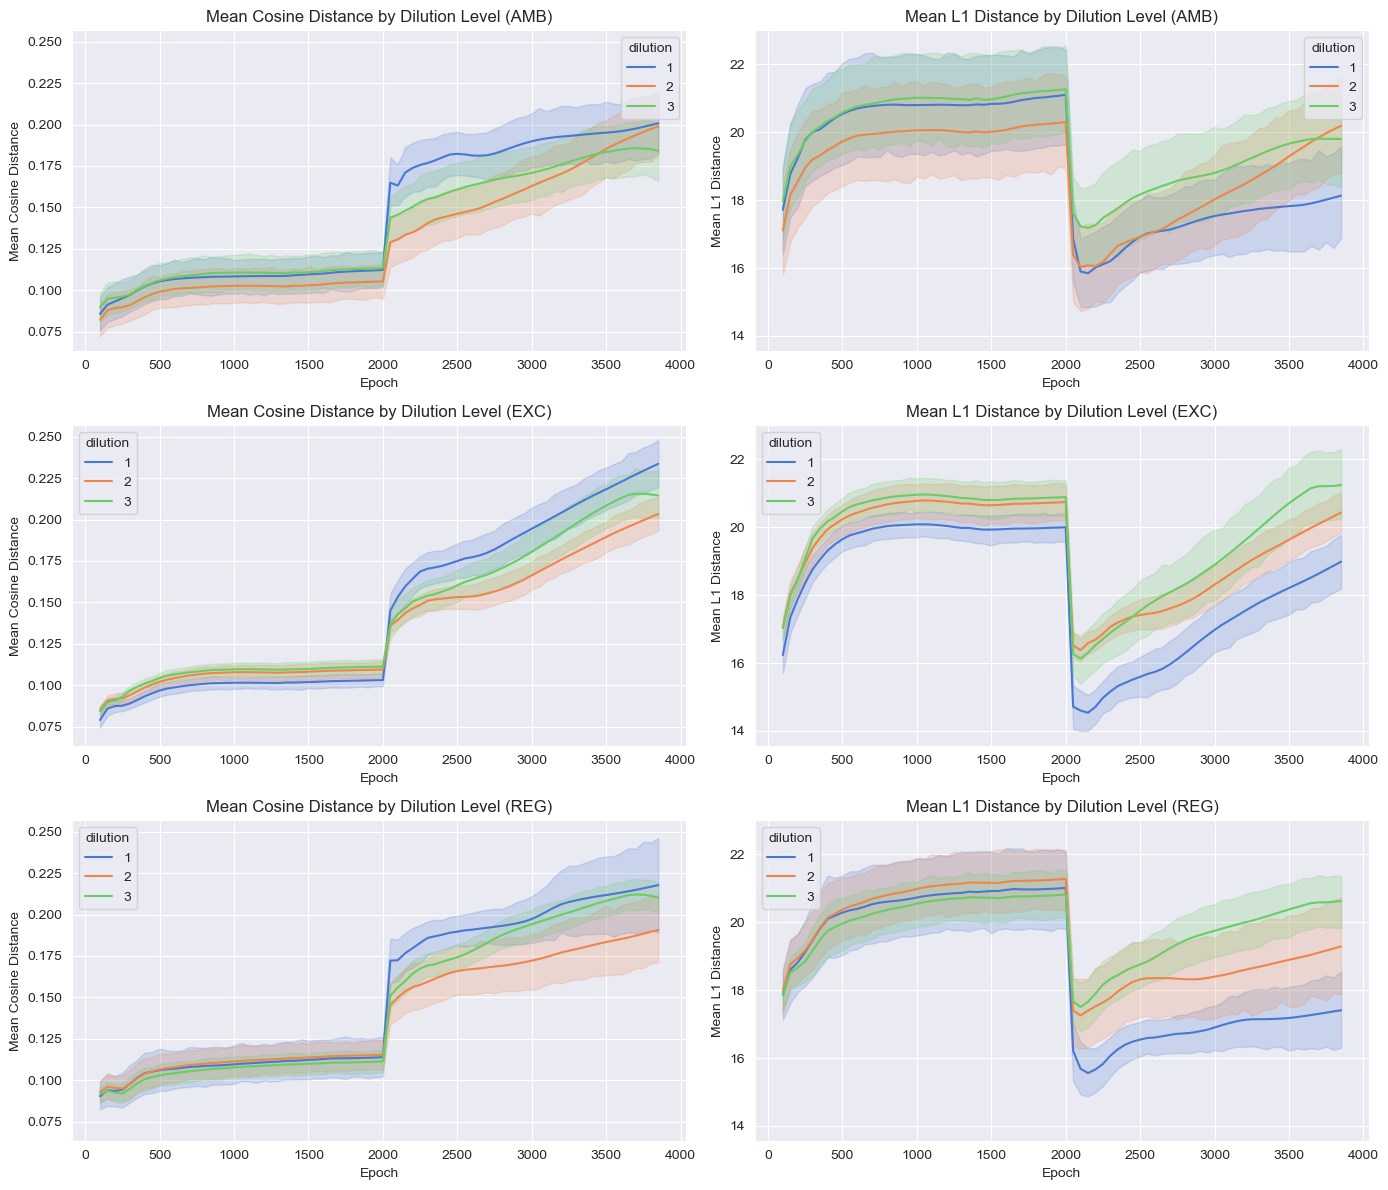

In [13]:
fig, axs = plt.subplots(3, 2, figsize=(14, 12), sharey='col')

for word_type, ax in zip(results_df['type'].unique(), axs):
    sns.lineplot(data=results_df[results_df['type'] == word_type], x='epoch', y='mean_cosine_distance', hue='dilution',
                 ax=ax[0], ci=68, palette='muted')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Mean Cosine Distance')
    ax[0].set_title(f'Mean Cosine Distance by Dilution Level ({word_type})')

    sns.lineplot(data=results_df[results_df['type'] == word_type], x='epoch', y='mean_l1_distance', hue='dilution',
                 ax=ax[1], ci=68, palette='muted')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Mean L1 Distance')
    ax[1].set_title(f'Mean L1 Distance by Dilution Level ({word_type})')

plt.tight_layout()
plt.show()

In the next 3 sets of graphs, we look at each dilution level individually, but combine all three regularity types in the same plot.

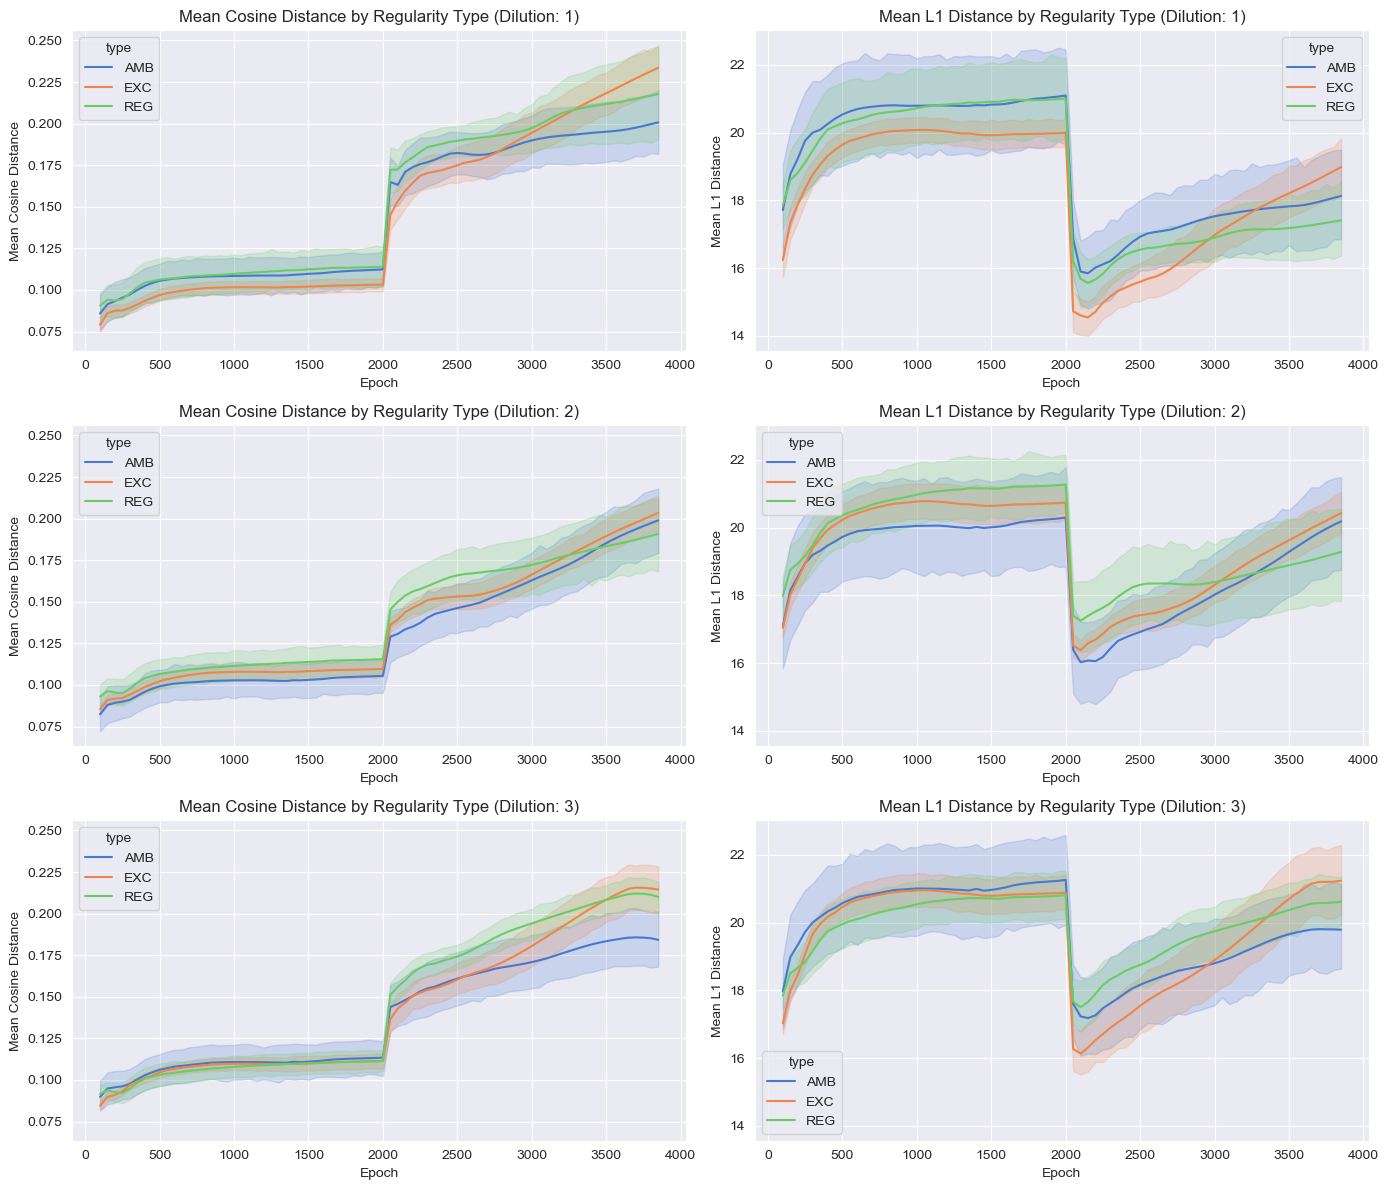

In [14]:
fig, axs = plt.subplots(3, 2, figsize=(14, 12), sharey='col')

for dilution, ax in zip(results_df['dilution'].unique(), axs):
    sns.lineplot(data=results_df[results_df['dilution'] == dilution], x='epoch', y='mean_cosine_distance', hue='type',
                 ax=ax[0], ci=68, palette='muted')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Mean Cosine Distance')
    ax[0].set_title(f'Mean Cosine Distance by Regularity Type (Dilution: {dilution})')

    sns.lineplot(data=results_df[results_df['dilution'] == dilution], x='epoch', y='mean_l1_distance', hue='type',
                 ax=ax[1], ci=68, palette='muted')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Mean L1 Distance')
    ax[1].set_title(f'Mean L1 Distance by Regularity Type (Dilution: {dilution})')

plt.tight_layout()
plt.show()

## Distance by Word Set
* We refer to each anchor/probe set by the first anchor/probe.

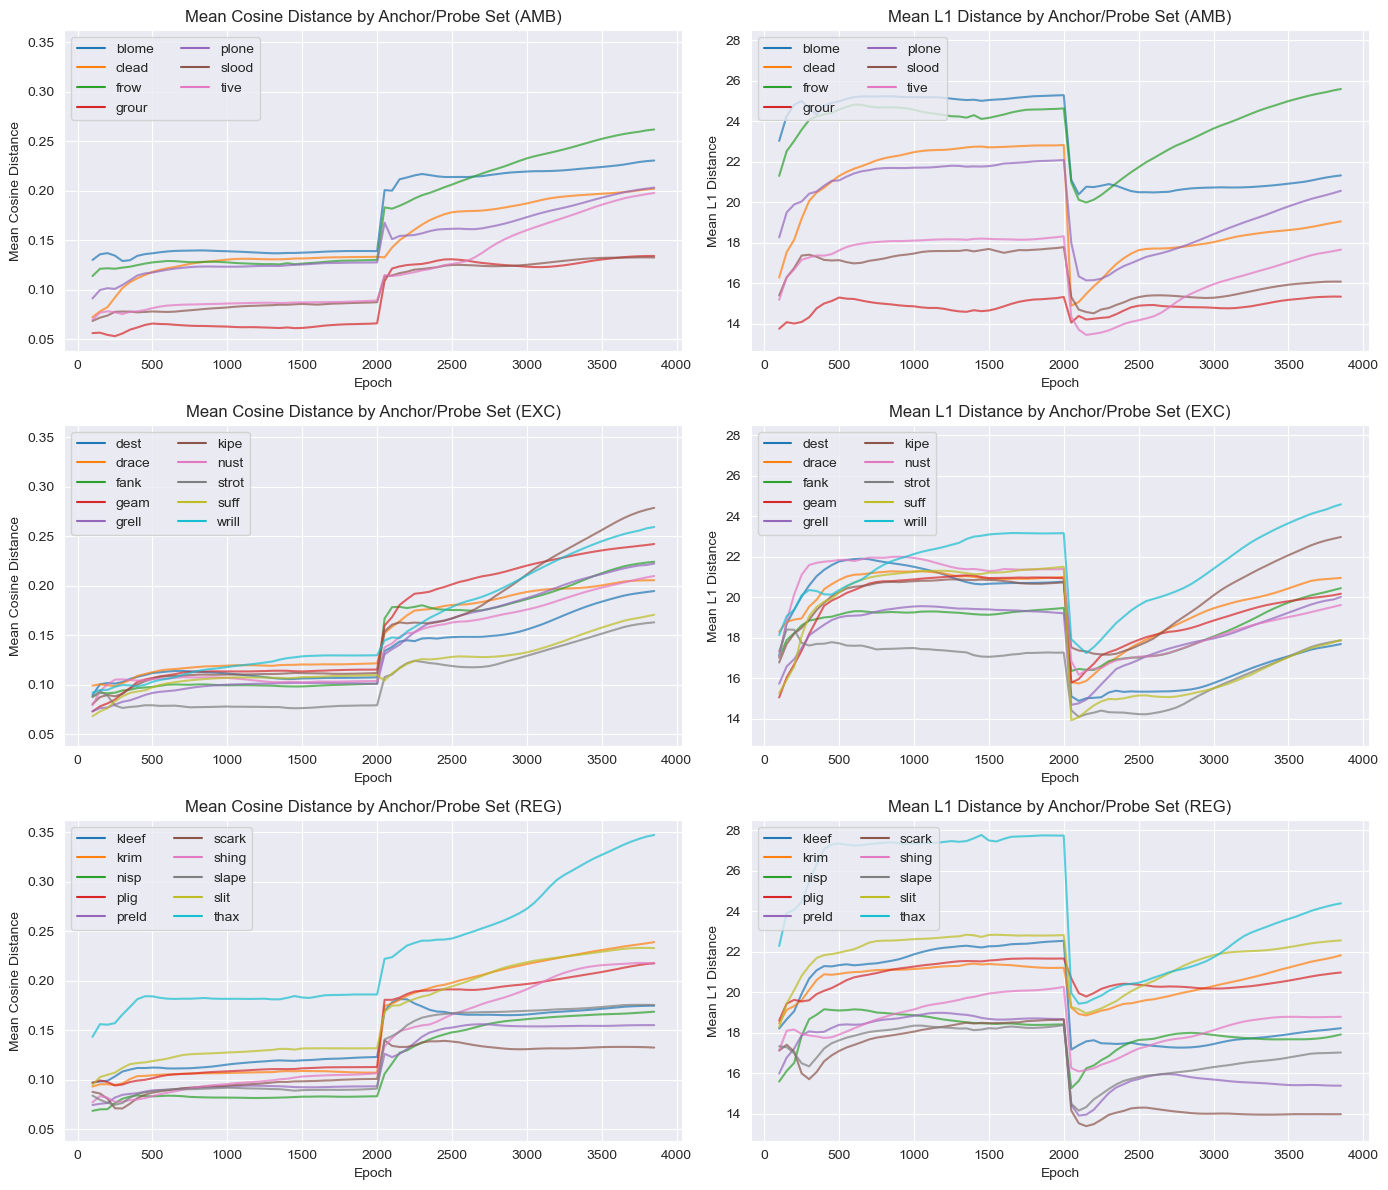

In [15]:
fig, axs = plt.subplots(3, 2, figsize=(14, 12), sharey='col')

for word_type, ax in zip(results_df['type'].unique(), axs):
    sns.lineplot(data=results_df[results_df['type'] == word_type], x='epoch', y='mean_cosine_distance', hue='first_anchor',
                 alpha=0.7, ax=ax[0], ci=None)
    ax[0].legend(ncol=2, loc='upper left')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Mean Cosine Distance')
    ax[0].set_title(f'Mean Cosine Distance by {TYPE.title()} Set ({word_type})')

    sns.lineplot(data=results_df[results_df['type'] == word_type], x='epoch', y='mean_l1_distance', hue='first_anchor',
                 alpha=0.7, ax=ax[1], ci=None)
    ax[1].legend(ncol=2, loc='upper left')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Mean L1 Distance')
    ax[1].set_title(f'Mean L1 Distance by {TYPE.title()} Set ({word_type})')

plt.tight_layout()
plt.show()